In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [6]:
season = ""
episode = ""
scene = ""
data = []
with open("data/all_scripts.txt") as f:
    for line in f.readlines():
        line = line[:-1]
        if line.startswith(">> "):
            season = int(line[10:12])
            episode = line[3:]
            continue
        if line.startswith("> "):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1)
        data.append([season, episode, scene, character, line])
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])
lines



Season                                            Episode  \
0           1               Series 01 Episode 01 – Pilot Episode   
1           1               Series 01 Episode 01 – Pilot Episode   
2           1               Series 01 Episode 01 – Pilot Episode   
3           1               Series 01 Episode 01 – Pilot Episode   
4           1               Series 01 Episode 01 – Pilot Episode   
...       ...                                                ...   
51287      10  Series 10 Episode 24 – The Long Distance Disso...   
51288      10  Series 10 Episode 24 – The Long Distance Disso...   
51289      10  Series 10 Episode 24 – The Long Distance Disso...   
51290      10  Series 10 Episode 24 – The Long Distance Disso...   
51291      10  Series 10 Episode 24 – The Long Distance Disso...   

                             Scene     Character  \
0      A corridor at a sperm bank.       Sheldon   
1      A corridor at a sperm bank.       Leonard   
2      A corridor at a sperm bank.       Sheldon   
3      A corridor at a sperm bank.       Leonard   
4      A corridor at a sperm bank.  Receptionist   
...                            ...           ...   
51287            Sheldon’s office.        Ramona   
51288            Sheldon’s office.       Sheldon   
51289            Sheldon’s office.        Ramona   
51290            Sheldon’s office.       Sheldon   
51291                   Princeton.       Sheldon   

                                                    Line  
0      So if a photon is directed through a plane wit...  
1                             Agreed, what’s your point?  
2      There’s no point, I just think it’s a good ide...  
3                                             Excuse me?  
4                                               Hang on.  
...                                                  ...  
51287  Mmm. No big deal, I enjoy spending time with you.  
51288  And I with you. Question, are you seeking a ro...  
51289                                    What if I were?  
51290  Well, that would raise a number of problems. W...  
51291  (Knock, knock, knock) Amy. (Knock, knock, knoc...  

[51292 rows x 5 columns]

**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [59]:
# My Sol
'''
recurrent_characters = lines.groupby("Character").agg("size")
recurrent_characters = recurrent_characters[recurrent_characters > 90]
del recurrent_characters["Man"]
recurrent_characters
'''

# Sol
recurrent_chars = lines.groupby("Character").count()[["Line"]] # count() returns count forn each column in group formed by groupby() --> [["Line"]] keeps only "Line" col in the final df
recurrent_chars = recurrent_chars[recurrent_chars["Line"] > 90]
recurrent_chars = recurrent_chars.drop("Man") # "Character" is index of df due to groupby("Character")
recurrent_chars


Line
Character          
Amy            3472
Arthur          130
Bernadette     2690
Bert             95
Beverley        162
Emily           164
Howard         5872
Kripke          106
Leonard        9829
Leslie          116
Mrs Cooper      213
Mrs Wolowitz    136
Penny          7677
Priya           222
Raj            4779
Sheldon       11689
Stuart          733
Wil             126
Zack            135

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [27]:
'''
Tasks: 
    - if a char from EXCLUDE_CHARS is in line, replace with whitespace i-e " "
    - lowercase the line
'''

def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()

lines["Line"] = lines["Line"].apply(clean_line)
lines.head()

Season                               Episode                        Scene  \
0       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
1       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
2       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
3       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
4       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   

      Character                                               Line  
0       Sheldon  so if a photon is directed through a plane wit...  
1       Leonard                         agreed  what s your point   
2       Sheldon  there s no point  i just think it s a good ide...  
3       Leonard                                         excuse me   
4  Receptionist                                           hang on

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [ ]:
# create a list of all words in dataset
all_words = []
for idx, row in lines.iterrows():
    line = row["Line"]
    words = line.split()
    all_words.extend(words)

# convert list of words to df (each row is a word)
all_words = pd.DataFrame(all_words)
all_words.columns = ["Word"]

# create a new col "Frequency" & initialize it with all 0s
all_words["Frequency"] = 0 

# groupby Word & then do count to get word counts in "Frequency" col (which is the only other col in the df)
corpus_frequency = all_words.groupby("Word").count()
corpus_frequency


Frequency
Word               
0                 6
00                5
000              33
000lb             1
01100111          1
...             ...
…tion             1
…when             1
…who              1
‭yeah             1
♪                 1

[21666 rows x 1 columns]

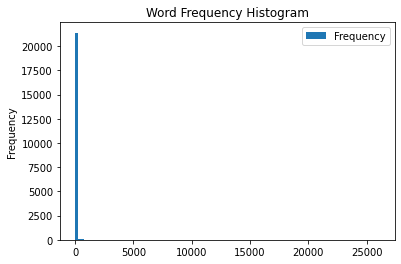

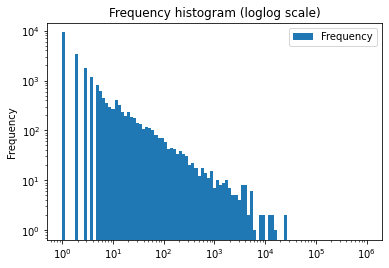

In [68]:
corpus_frequency.plot.hist(column=["Frequency"], bins=100, title="Word Frequency Histogram") # --> large freq barely visible, so need to do log-scale (both axis) below

corpus_frequency.plot.hist(column=["Frequency"], loglog=True, bins=np.logspace(0, 6, 100), title="Frequency histogram (loglog scale)");
# As seeb in the log-scale graph, distribution of word frequencies follows a power law. 
# So, it was indeed helpful to visualize this frequency is on a log-log scale.


### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [70]:
lines # just for reference

Season                                            Episode  \
0           1               Series 01 Episode 01 – Pilot Episode   
1           1               Series 01 Episode 01 – Pilot Episode   
2           1               Series 01 Episode 01 – Pilot Episode   
3           1               Series 01 Episode 01 – Pilot Episode   
4           1               Series 01 Episode 01 – Pilot Episode   
...       ...                                                ...   
51287      10  Series 10 Episode 24 – The Long Distance Disso...   
51288      10  Series 10 Episode 24 – The Long Distance Disso...   
51289      10  Series 10 Episode 24 – The Long Distance Disso...   
51290      10  Series 10 Episode 24 – The Long Distance Disso...   
51291      10  Series 10 Episode 24 – The Long Distance Disso...   

                             Scene     Character  \
0      A corridor at a sperm bank.       Sheldon   
1      A corridor at a sperm bank.       Leonard   
2      A corridor at a sperm bank.       Sheldon   
3      A corridor at a sperm bank.       Leonard   
4      A corridor at a sperm bank.  Receptionist   
...                            ...           ...   
51287            Sheldon’s office.        Ramona   
51288            Sheldon’s office.       Sheldon   
51289            Sheldon’s office.        Ramona   
51290            Sheldon’s office.       Sheldon   
51291                   Princeton.       Sheldon   

                                                    Line  
0      so if a photon is directed through a plane wit...  
1                             agreed  what s your point   
2      there s no point  i just think it s a good ide...  
3                                             excuse me   
4                                               hang on   
...                                                  ...  
51287  mmm  no big deal  i enjoy spending time with you   
51288  and i with you  question  are you seeking a ro...  
51289                                    what if i were   
51290  well  that would raise a number of problems  w...  
51291   knock  knock  knock  amy   knock  knock  knoc...  

[51292 rows x 5 columns]

In [113]:
# create a new col "NumWords" that contains num of words for each line
lines["NumWords"] = lines["Line"].apply(lambda x: len( x.split() ) ) 

words_per_char = lines.groupby("Character").sum()["NumWords"] # keep only "NumWords" col after sum()
words_per_char = words_per_char.reset_index() # reset index so "Character" & "NumWords" appear as cols in df (NOTE: "NumWords" won't appear as a col name otherwise as df will instead be a pd.Series since there is only idx & 1 col after prev line)
words_per_char


Character  NumWords
0                 Abby        24
1              Actress        28
2                 Adam       222
3    Air Force Officer        33
4                 Alex       624
..                 ...       ...
193              Woman       207
194        Woman on TV        23
195              Wyatt       595
196               Zack      1427
197             Zombie        26

[198 rows x 2 columns]

In [114]:
max_words = words_per_char["NumWords"].max()

max_words_per_char = words_per_char[words_per_char["NumWords"] == max_words]
row = max_words_per_char.iloc[0] # consider 1st character only if there are multiple with max words

print(f"most talkative character is {row['Character']} with {row['NumWords']} words")

most talkative character is Sheldon with 185388 words


In [116]:
# Provided Solution (enhanced version)

list_of_recurrent_chars= recurrent_chars.index # index of recurrent_chars is "Character"

words_per_char = lines.groupby("Character").sum()["NumWords"] # keep only "NumWords" col after sum()
# NOTE: no index reset done here, words_per_char is pd.Series! (with "Character" as idx & "NumWords" are values)

# Only keep data for recurrent characters in 'words_per_char' pd.Series
words_per_char = words_per_char[list_of_recurrent_chars]

print("Most talkative character: ", words_per_char.idxmax()) # idxmax returns idx of max value in pd.Series 'words_per_char'

Most talkative character:  Sheldon


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [ ]:
'''
IDEA:
    - Split dialogue lines: test & train set
    - Find all words ONLY spoken by Sheldon in the train set
    - Find in how many lines of test set (dialogue lines) such words are present (at least one) --> if they are present only then it would be possible to identify that dialogue was spoken by Sheldon
    - If in 70% of the lines in test set such words are present, then it is possible that Sheldon can guess correctly. Otherwise, achieving 70% accuracy is impossible.
'''

In [117]:
lines # just for reference

Season                                            Episode  \
0           1               Series 01 Episode 01 – Pilot Episode   
1           1               Series 01 Episode 01 – Pilot Episode   
2           1               Series 01 Episode 01 – Pilot Episode   
3           1               Series 01 Episode 01 – Pilot Episode   
4           1               Series 01 Episode 01 – Pilot Episode   
...       ...                                                ...   
51287      10  Series 10 Episode 24 – The Long Distance Disso...   
51288      10  Series 10 Episode 24 – The Long Distance Disso...   
51289      10  Series 10 Episode 24 – The Long Distance Disso...   
51290      10  Series 10 Episode 24 – The Long Distance Disso...   
51291      10  Series 10 Episode 24 – The Long Distance Disso...   

                             Scene     Character  \
0      A corridor at a sperm bank.       Sheldon   
1      A corridor at a sperm bank.       Leonard   
2      A corridor at a sperm bank.       Sheldon   
3      A corridor at a sperm bank.       Leonard   
4      A corridor at a sperm bank.  Receptionist   
...                            ...           ...   
51287            Sheldon’s office.        Ramona   
51288            Sheldon’s office.       Sheldon   
51289            Sheldon’s office.        Ramona   
51290            Sheldon’s office.       Sheldon   
51291                   Princeton.       Sheldon   

                                                    Line  NumWords  
0      so if a photon is directed through a plane wit...        57  
1                             agreed  what s your point          5  
2      there s no point  i just think it s a good ide...        16  
3                                             excuse me          2  
4                                               hang on          2  
...                                                  ...       ...  
51287  mmm  no big deal  i enjoy spending time with you         10  
51288  and i with you  question  are you seeking a ro...        13  
51289                                    what if i were          4  
51290  well  that would raise a number of problems  w...        21  
51291   knock  knock  knock  amy   knock  knock  knoc...        16  

[51292 rows x 6 columns]

In [118]:
final_season = lines["Season"].max()
train_set = lines[lines["Season"] <= final_season - 2] # train_set includes all seasons except last 2
train_set.head()


Season                               Episode                        Scene  \
0       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
1       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
2       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
3       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   
4       1  Series 01 Episode 01 – Pilot Episode  A corridor at a sperm bank.   

      Character                                               Line  NumWords  
0       Sheldon  so if a photon is directed through a plane wit...        57  
1       Leonard                         agreed  what s your point          5  
2       Sheldon  there s no point  i just think it s a good ide...        16  
3       Leonard                                         excuse me          2  
4  Receptionist                                           hang on          2

In [119]:
test_set = lines[lines["Season"] > final_season - 2] # test_set includes remaining last 2 seasons
test_set.head()

Season                                          Episode  \
40354       9  Series 09 Episode 01 – The Matrimonial Momentum   
40355       9  Series 09 Episode 01 – The Matrimonial Momentum   
40356       9  Series 09 Episode 01 – The Matrimonial Momentum   
40357       9  Series 09 Episode 01 – The Matrimonial Momentum   
40358       9  Series 09 Episode 01 – The Matrimonial Momentum   

                   Scene Character  \
40354  A Wedding Chapel.     Penny   
40355  A Wedding Chapel.   Leonard   
40356  A Wedding Chapel.     Penny   
40357  A Wedding Chapel.   Leonard   
40358  A Wedding Chapel.     Penny   

                                                    Line  NumWords  
40354                 so  what package are you thinking          6  
40355  mm  this one comes with music and flowers  oh ...        19  
40356                            why would we want that          5  
40357  ‘cause there s a lot of gorgeous blondes out t...        26  
40358  whatever  put us on the internet  i ve always ...        16

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [172]:
# Create a df containing word & character that spoke it for all the words in the dataset
'''
- pd.Series( row["Character"], row['Line'].split() )
    - Syntax: pd.Series(data_val, <idx> OR <[list of idx]>)
    - idx here is a list instead of just one i-e words returned by .split()
    - So, same "Character" will be repeated for each idx (i-e word) in the list of idx
    - NOTE: see example in next cell
'''
words_for_chars = pd.concat(  [ pd.Series(row["Character"], row['Line'].split())  for  _, row in train_set.iterrows() ]  ).reset_index()
words_for_chars.columns = ["Word", "Character"]
words_for_chars


Word Character
0           so   Sheldon
1           if   Sheldon
2            a   Sheldon
3       photon   Sheldon
4           is   Sheldon
...        ...       ...
493512       i   Sheldon
493513      do   Sheldon
493514    with   Sheldon
493515    this   Sheldon
493516     one   Sheldon

[493517 rows x 2 columns]

In [142]:
# Example to understand: pd.Series(row["Character"], row['Line'].split())
data = "John"
list_of_idx = ["a", "b", "c"]
pd.Series(data, list_of_idx)

a    John
b    John
c    John
dtype: object

In [173]:
# Groupby "Word" in order to have col "Characters" containing all characters that spoke that word
words_for_chars = words_for_chars.groupby("Word") 

# just to show
for idx_word, group in words_for_chars:
    if str.isalpha(idx_word):
        print(f"{'-'*10} word: '{idx_word}' {'-'*10}")
        print(group)
   

---------- word: 'a' ----------
       Word Character
2         a   Sheldon
7         a   Sheldon
71        a   Sheldon
75        a   Sheldon
189       a   Leonard
...     ...       ...
493231    a     Penny
493255    a   Leonard
493379    a   Leonard
493427    a   Sheldon
493486    a       Amy

[11427 rows x 2 columns]
---------- word: 'aa' ----------
      Word    Character
35027   aa      Leonard
35034   aa      Leonard
35988   aa  Gablehouser
36076   aa  Gablehouser
36199   aa  Gablehouser
36297   aa  Gablehouser
36316   aa  Gablehouser
36430   aa  Gablehouser
---------- word: 'aaaa' ----------
       Word Character
37030  aaaa   Leonard
---------- word: 'aaaaaaaaaaaaaa' ----------
                 Word Character
60745  aaaaaaaaaaaaaa   Sheldon
---------- word: 'aaaaaaaaaaaaaaaaaa' ----------
                     Word Character
60739  aaaaaaaaaaaaaaaaaa   Sheldon
---------- word: 'aaaaaaagh' ----------
             Word Character
479128  aaaaaaagh   Sheldon
---------- word: 'aaaaaa

In [ ]:
# Only have unique characters in "Characters" col (not duplicate character)
words_for_chars = words_for_chars["Character"].apply(set) # apply set() func to the values of the "Character" col in each group to turn them into a set & thus make them unique
words_for_chars

# NOTE: 'words_for_chars' is now pd.Series! index: Word, val: set of Characters (not a single Char!)

Word
0                            {Missy, Sheldon, Howard, Leonard}
00                                           {Leonard, Howard}
000          {Stuart, Leonard, Sheldon, Bernadette, Raj, Ho...
000lb                                                {Sheldon}
01100111                                             {Sheldon}
                                   ...                        
…thousand                                            {Leonard}
…tion                                                {Sheldon}
…when                                                  {Penny}
…who                                                 {Leonard}
♪                                                        {Amy}
Name: Character, Length: 19993, dtype: object

In [177]:
# filter out words ONLY spoken by Sheldon (char == Sheldon AND len of chars col == 1)
'''
words_for_chars.apply(lambda x: "Sheldon" in x and len(x) == 1)
    - return True/False for each val in pd.Series 'words_for_chars' where both condition is met
    - when given to words_for_chars[...] --> return all vals in word_for_chars where condition is met
    - .index at the end --> return indices of such vals i-e their "Word"

'''
sheldon_words = words_for_chars[words_for_chars.apply(lambda x: "Sheldon" in x and len(x) == 1)].index
sheldon_words

Index(['000lb', '01100111', '0700', '08', '102', '112', '114', '11n', '11pm',
       '12th',
       ...
       '“sarcasm”', '“thanks', '“waltz”', '“with', '“world', '“would', '“ye',
       '…playing', '…the', '…tion'],
      dtype='object', name='Word', length=5066)

In [ ]:
# finds if a dialogue line contains a word (at least one) ONLY spoken by Sheldon
def contains_sheldon_words(line):
    for word in sheldon_words:
        if word in line.split():
            return True
    return False

# check for each dialogue line if it contains a word ONLY spoken by Sheldon --> it kind of classify it as Spoken by Sheldon (by assigning True/False)
test_pred = test_set["Line"].apply(contains_sheldon_words)

# Groun truth --> get all dialogue lines which was spoken by Sheldon
test_true = test_set["Character"] == "Sheldon"

# Max possible accuracy
print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))

Accuracy:  0.7825013713658804
